In [1]:
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from math import sqrt

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score
import kerastuner as kt
import tensorflow.compat.v1 as tf

from collections import Counter 
import pickle
import pandas as pd
import collections
import seaborn as sns

In [7]:
Dataset1_Smiles_P = pd.read_csv("dataset1_imputed_all.csv")
Dataset1_Smiles_P = Dataset1_Smiles_P.groupby('Smiles').mean().reset_index()
Dataset1_Smiles_P

,Smiles,Unnamed: 0,index,Year,He,H2,O2,N2,CO2,CH4,...,log10_O2_Bayesian,log10_N2_Bayesian,log10_CO2_Bayesian,log10_CH4_Bayesian,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,*/C(=C(\*)c1ccc(-c2ccc(C(C)(C)C)cc2)cc1)c1ccccc1,750.5,269.5,2010.0,215.0,455.0,195.00,70.500,1220.00,190.000,...,2.264458,1.820241,3.064200,2.247077,2.322711,2.640971,2.264458,1.820241,3.064200,2.247077
1,*/C(=C(\*)c1ccc(-c2ccc([Si](C)(C)C)cc2)cc1)c1c...,743.0,262.0,2010.0,370.0,810.0,390.00,160.000,2200.00,450.000,...,2.591065,2.204120,3.342423,2.653213,2.568202,2.908485,2.591065,2.204120,3.342423,2.653213
2,*/C(=C(\*)c1ccc(-c2ccccc2)cc1)c1ccccc1,749.0,268.0,2010.0,200.0,440.0,180.00,65.000,1300.00,170.000,...,2.255273,1.812913,3.113943,2.230449,2.301030,2.643453,2.255273,1.812913,3.113943,2.230449
3,*/C(=C(\*)c1ccc(C(C)(C)C)cc1)c1ccc(O)cc1,707.0,226.0,2006.0,190.0,340.0,82.00,23.000,530.00,46.000,...,1.913814,1.361728,2.724276,1.662758,2.278754,2.531479,1.913814,1.361728,2.724276,1.662758
4,*/C(=C(\*)c1ccc(C(C)(C)C)cc1)c1ccc(O[Si](C)(C)...,703.0,222.0,2006.0,530.0,1000.0,470.00,210.000,2300.00,540.000,...,2.672098,2.322219,3.361728,2.732394,2.724276,3.000000,2.672098,2.322219,3.361728,2.732394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,*c1ccc2c(c1)C1(CC2(C)C)CC(C)(C)c2ccc(N3C(=O)c4...,653.0,144.0,2013.0,332.0,624.0,208.00,65.000,1523.00,129.000,...,2.318063,1.812913,3.182700,2.110590,2.521138,2.795185,2.318063,1.812913,3.182700,2.110590
349,*c1cccc(N2C(=O)c3ccc(Oc4ccc(C(C)(C)c5ccc(Oc6cc...,409.5,409.5,1994.0,9.4,NaN,0.37,0.051,1.33,0.036,...,-0.434351,-1.231009,0.121595,-1.291081,0.927353,0.736209,-0.434351,-1.295008,0.103035,-1.443242
350,*c1cccc(N2C(=O)c3ccc(Oc4ccc(C5(c6ccc(Oc7ccc8c(...,543.0,543.0,1989.0,NaN,NaN,0.30,NaN,NaN,NaN,...,-0.522879,-1.214076,0.077487,-1.185679,0.874861,0.748087,-0.522879,-1.311811,0.037426,-1.428914
351,*c1cccc(N2C(=O)c3ccc(Oc4ccc5c(c4)C4(CC(C)(C)c6...,542.0,542.0,1989.0,NaN,NaN,2.82,NaN,NaN,NaN,...,0.450249,-0.168164,1.061415,-0.075697,1.294916,1.406761,0.450249,-0.120979,1.151142,-0.084523


In [3]:
X_fingerprints = pd.read_csv('X_fingerprints.csv')
X_fingerprints = X_fingerprints.drop(X_fingerprints.columns[0], axis=1)
X_fingerprints

,298,380,423,619,724,799,866,984,1116,1160,...,2706,2728,2814,2818,2854,2857,2925,2984,3093,3155
0,0,0,0,1,2,0,0,0,0,2,...,0,0,0,0,3,0,2,2,0,13
1,0,0,0,0,2,0,0,0,0,2,...,0,0,0,0,3,0,2,2,0,13
2,0,0,0,0,2,0,0,0,0,2,...,0,0,0,0,0,0,4,2,0,14
3,0,0,0,1,4,0,0,0,0,2,...,0,0,0,0,3,0,0,2,0,8
4,1,0,0,1,4,0,0,0,0,2,...,0,2,0,0,8,0,0,2,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,6,0,0,0,0,0,4,1,0,...,4,0,4,2,8,6,0,0,0,10
349,2,3,0,2,0,0,0,4,1,0,...,4,6,0,2,2,0,0,0,0,18
350,2,5,0,0,0,0,0,4,1,0,...,4,2,5,2,2,1,0,0,2,16
351,2,5,0,0,0,0,0,4,1,0,...,4,4,2,2,4,3,0,0,0,16


In [4]:
X_descriptors = pd.read_csv('X_descriptors.csv')
X_descriptors = X_descriptors.drop(X_descriptors.columns[0], axis=1)
X_descriptors

,0,1,2,3,4,5,6,7,8,14,...,178,180,187,188,189,196,198,200,205,206
0,2.333429,0.164923,2.333429,0.164923,0.479509,310.440,288.264,310.172151,118.0,0.625000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.402725,-1.216811,2.402725,0.169515,0.418236,326.515,304.339,326.149077,118.0,0.625000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.314907,0.184489,2.314907,0.184489,0.557853,254.332,240.220,254.109550,94.0,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.420806,0.127855,9.420806,0.127855,0.771337,250.341,232.197,250.135765,96.0,0.842105,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,6.449983,-1.769760,6.449983,0.125872,0.408536,364.605,332.349,364.222242,138.0,0.769231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,14.732718,-0.632621,14.732718,0.018773,0.190272,686.852,644.516,686.314458,260.0,0.461538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,13.238844,-0.568127,13.238844,0.058631,0.197023,592.607,568.415,592.163436,218.0,0.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,13.429798,-0.577844,13.429798,0.065072,0.163610,660.726,628.470,660.226037,246.0,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351,13.560843,-0.600562,13.560843,0.078563,0.176060,672.737,640.481,672.226037,250.0,0.549020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lassp Regression: Descriptors

In [18]:
X = X_descriptors
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = Dataset1_Smiles_P.iloc[:,-12:-6]
Y = np.array(Y)

In [19]:
# hyperparameters
#X_dataset_1, Y = shuffle(X_dataset_1, Y, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
alpha = 0.1
cv = 10

# build model
model = Lasso(alpha=alpha).fit(X_train, Y_train)
# get prediction
Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv) # cross-validation
Y_pred_test = cross_val_predict(model, X_test, Y_test, cv=cv)
# calculate the metrics
final_R2 = r2_score(Y_train,Y_pred_train)
final_MAE = mean_absolute_error(Y_train,Y_pred_train)
# metrics of the score
scores = cross_validate(model, X_train, Y_train, cv=cv,
scoring=('r2', 'neg_mean_absolute_error'),return_train_score=True)
# save the score
score_df = pd.DataFrame.from_dict(scores)
# save the model
#pickle.dump(model, open("./LASSO.model", 'wb'))
wts = model.coef_
#np.savetxt("./weights.txt", wts, fmt="%5.3f")


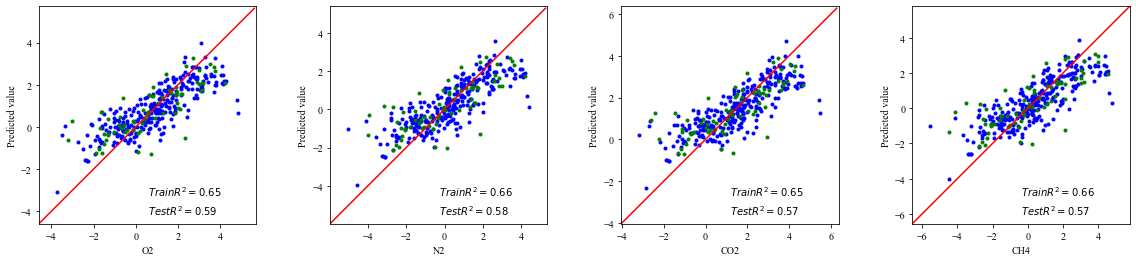

In [20]:
Columns = ['O2','N2','CO2','CH4']
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
plt.figure(figsize=(20,4))
for i in range(4):
    ax=plt.subplot(1, 4, i + 1)
    index = i + 2
    #flag1 = ~np.isnan(Y_train[:,index])
    plt.plot(Y_train[:,index], Y_pred_train[:,index], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    #flag2 = ~np.isnan(Y_test[:,index])
    plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')

In [105]:
weights_df = pd.DataFrame()
gasID = 5 #5 is for CH4
weights_df['descriptor_id'] = X_descriptors.columns
weights_df['wt'] = wts[gasID,:] #choose a single gas permeability to analyze
weights_df['abswt'] = abs(wts[gasID,:])

# find the main feature
coeffs = abs(wts[gasID,:])
coeffs = coeffs/sum(coeffs)
weights_df['ratio'] = coeffs

ordered_wts = weights_df.sort_values(['ratio'], ascending=0)
# add cumulative sum
ordered_wts['cumsum'] = ordered_wts['ratio'].to_numpy().cumsum()
ordered_wts[ordered_wts['cumsum'] <0.8]

print(ordered_wts)
print(Corr_df)

    descriptor_id        wt     abswt     ratio    cumsum
97            113 -0.480378  0.480378  0.129096  0.129096
85            101  0.470788  0.470788  0.126519  0.255615
10             15 -0.398746  0.398746  0.107158  0.362773
64             79  0.341377  0.341377  0.091741  0.454514
93            109  0.330737  0.330737  0.088882  0.543396
..            ...       ...       ...       ...       ...
41             55 -0.000000  0.000000  0.000000  1.000000
40             53  0.000000  0.000000  0.000000  1.000000
39             52 -0.000000  0.000000  0.000000  1.000000
38             51 -0.000000  0.000000  0.000000  1.000000
145           206  0.000000  0.000000  0.000000  1.000000

[146 rows x 5 columns]
      index           0
0         0   966434816
1         1  3870277633
2         2   254107648
3         3   900325378
4         4  3925172229
...     ...         ...
3204   3204   351010789
3205   3205  4038508520
3206   3206  1757216757
3207   3207  3533643770
3208   3208  151

In [100]:
ordered_wts[ordered_wts['cumsum'] <0.8]

,descriptor_id,wt,abswt,ratio,cumsum
97,113,-0.480378,0.480378,0.129096,0.129096
85,101,0.470788,0.470788,0.126519,0.255615
10,15,-0.398746,0.398746,0.107158,0.362773
64,79,0.341377,0.341377,0.091741,0.454514
93,109,0.330737,0.330737,0.088882,0.543396
58,73,-0.293812,0.293812,0.078958,0.622354
82,98,-0.181145,0.181145,0.048681,0.671035
76,92,-0.177668,0.177668,0.047746,0.718781
108,124,-0.164024,0.164024,0.044079,0.762861


### Lasso Regression: Fingerprints

In [15]:
X = X_fingerprints
Y = Dataset1_Smiles_P.iloc[:,-12:-6]
Y = np.array(Y)

In [16]:
# hyperparameters
#X_dataset_1, Y = shuffle(X_dataset_1, Y, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
alpha = 0.1
cv = 10

# build model
model = Lasso(alpha=alpha).fit(X_train, Y_train)
# get prediction
Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv) # cross-validation
Y_pred_test = cross_val_predict(model, X_test, Y_test, cv=cv)
# calculate the metrics
final_R2 = r2_score(Y_train,Y_pred_train)
final_MAE = mean_absolute_error(Y_train,Y_pred_train)
# metrics of the score
scores = cross_validate(model, X_train, Y_train, cv=cv,
scoring=('r2', 'neg_mean_absolute_error'),return_train_score=True)
# save the score
score_df = pd.DataFrame.from_dict(scores)
# save the model
#pickle.dump(model, open("./LASSO.model", 'wb'))
wts = model.coef_
#np.savetxt("./weights.txt", wts, fmt="%5.3f")


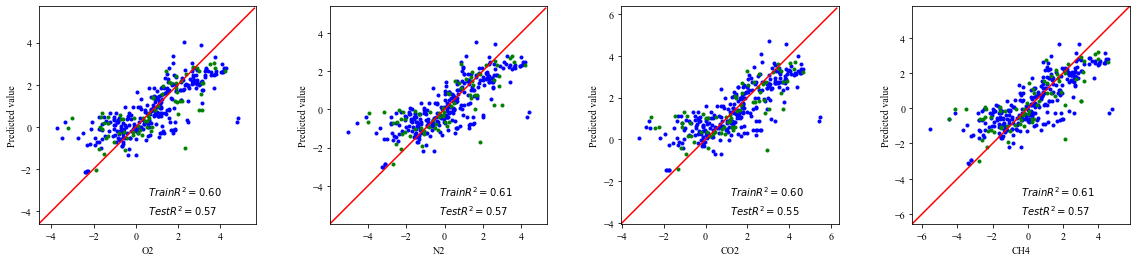

In [17]:
Columns = ['O2','N2','CO2','CH4']
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
plt.figure(figsize=(20,4))
for i in range(4):
    ax=plt.subplot(1, 4, i + 1)
    index = i + 2
    #flag1 = ~np.isnan(Y_train[:,index])
    plt.plot(Y_train[:,index], Y_pred_train[:,index], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    #flag2 = ~np.isnan(Y_test[:,index])
    plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')

In [23]:
weights_df = pd.DataFrame()
gasID = 5 #5 is for CH4
weights_df['fingerprint_id'] = Zero_Sum[Zero_Sum < NumberOfZero].index
weights_df['wt'] = wts[gasID,:] #choose a single gas permeability to analyze
weights_df['abswt'] = abs(wts[gasID,:])

# find the main feature
coeffs = abs(wts[gasID,:])
coeffs = coeffs/sum(coeffs)
weights_df['ratio'] = coeffs

ordered_wts = weights_df.sort_values(['ratio'], ascending=0)
# add cumulative sum
ordered_wts['cumsum'] = ordered_wts['ratio'].to_numpy().cumsum()
ordered_wts[ordered_wts['cumsum'] <0.8]

print(ordered_wts)
print(Corr_df)

In [31]:
ordered_wts[ordered_wts['cumsum'] <0.8]

,descriptor_id,wt,abswt,ratio,cumsum
18,1781,0.541542,0.541542,0.253058,0.253058
37,2706,-0.424630,0.424630,0.198426,0.451483
0,298,-0.329907,0.329907,0.154163,0.605646
41,2854,0.231124,0.231124,0.108002,0.713648
44,2984,0.134475,0.134475,0.062839,0.776487


### Random Forest: Fingerprints

In [12]:
X = X_fingerprints
Y = Dataset1_Smiles_P.iloc[:,-12:-6]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [13]:
model = RandomForestRegressor(n_estimators=100, bootstrap = True, max_features = 'sqrt')
history = model.fit(X_train, Y_train)

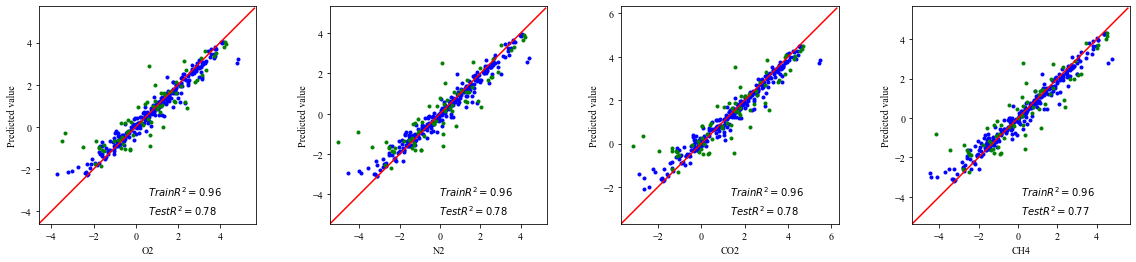

In [14]:
Columns = ['O2','N2','CO2','CH4']
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
Y_train = Y_train.to_numpy()
Y_test  = Y_test.to_numpy()
plt.figure(figsize=(20,4))
for i in range(4):
    ax=plt.subplot(1, 4, i + 1)
    index = i + 2
    #flag1 = ~np.isnan(Y_train[:,index])
    plt.plot(Y_train[:,index], Y_pred_train[:,index], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    #flag2 = ~np.isnan(Y_test[:,index])
    plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')

### 1D CNN: Smiles String

In [21]:
smiles = Dataset1_Smiles_P['Smiles']
START_TOKEN = '?'
END_TOKEN = '!'
NULL_TOKEN = '~'
embedding_dim = 64
MAX_LENGTH = 128

V = sorted(set(''.join(smiles.unique().tolist())))
V.append(END_TOKEN)
V.append(NULL_TOKEN)
#V = shuffle(V, random_state=3)
vocab_dim = len(V)

smiles_ = [np.array([V.index(c) for c in s] + [V.index(END_TOKEN)]).astype(np.int32) for s in smiles]
smilesdf = pd.DataFrame(smiles_, index=smiles.index)
smilesdf = smilesdf.fillna(value=V.index(NULL_TOKEN))
smilesdf

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,4,6,19,2,17.0,19.0,2.0,26.0,4.0,3.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
1,4,6,19,2,17.0,19.0,2.0,26.0,4.0,3.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
2,4,6,19,2,17.0,19.0,2.0,26.0,4.0,3.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
3,4,6,19,2,17.0,19.0,2.0,26.0,4.0,3.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
4,4,6,19,2,17.0,19.0,2.0,26.0,4.0,3.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,4,28,8,28,28.0,28.0,9.0,28.0,2.0,28.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
349,4,28,8,28,28.0,28.0,28.0,2.0,21.0,9.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
350,4,28,8,28,28.0,28.0,28.0,2.0,21.0,9.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
351,4,28,8,28,28.0,28.0,28.0,2.0,21.0,9.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0


In [22]:
Y = Dataset1_Smiles_P.iloc[:,-12:-6]
Y = np.array(Y)
X = np.array(smilesdf, dtype=np.int32)
X = X[:, :MAX_LENGTH]
X = np.where(np.isnan(X), V.index(NULL_TOKEN), X)
X= X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
embedding = tf.random_normal((vocab_dim, embedding_dim), 0, .1)
#new X in the embedding space
X_train = tf.nn.embedding_lookup(embedding, X_train)
X_test = tf.nn.embedding_lookup(embedding, X_test)

In [24]:
X_train.shape

TensorShape([282, 128, 1, 64])

In [25]:
model = Sequential()

model.add(Conv1D(64, 3, activation='relu', strides=4, padding='same')) #input_shape = (X_train.shape[0], X_train.shape[1],X_train.shape[2])
model.add(Conv1D(32, 3, activation='relu', strides=4, padding='same'))
model.add(Conv1D(16, 3, activation='relu', strides=4, padding='same'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(units = 8, activation='relu'))
model.add(Dense(units = 8, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(6))
optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
history=model.fit(x=X_train,y=Y_train,epochs=50,batch_size=64,validation_split=0.2)

Epoch 1/50
4/4 [==============================] - 1s 79ms/step - loss: 1.6968 - val_loss: 1.5644
Epoch 2/50
4/4 [==============================] - 0s 33ms/step - loss: 1.5969 - val_loss: 1.5040
Epoch 3/50
4/4 [==============================] - 0s 28ms/step - loss: 1.5645 - val_loss: 1.4128
Epoch 4/50
4/4 [==============================] - 0s 29ms/step - loss: 1.4117 - val_loss: 1.3364
Epoch 5/50
4/4 [==============================] - 0s 29ms/step - loss: 1.4217 - val_loss: 1.2811
Epoch 6/50
4/4 [==============================] - 0s 29ms/step - loss: 1.2913 - val_loss: 1.2047
Epoch 7/50
4/4 [==============================] - 0s 29ms/step - loss: 1.1967 - val_loss: 1.0956
Epoch 8/50
4/4 [==============================] - 0s 28ms/step - loss: 1.1607 - val_loss: 0.9797
Epoch 9/50
4/4 [==============================] - ETA: 0s - loss: 1.070 - 0s 28ms/step - loss: 1.0170 - val_loss: 0.9022
Epoch 10/50
4/4 [==============================] - 0s 31ms/step - loss: 0.8774 - val_loss: 0.8619
Epoch

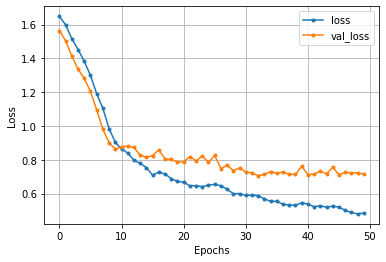

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig("./DNN_fingerprint_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

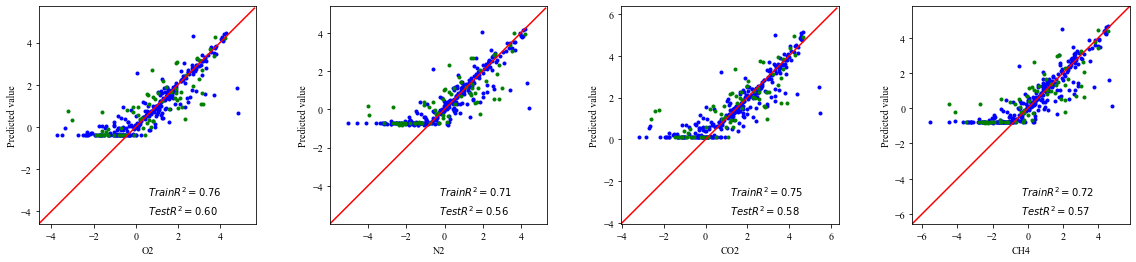

In [27]:
Columns = ['O2','N2','CO2','CH4']
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
plt.figure(figsize=(20,4))
for i in range(4):
    ax=plt.subplot(1, 4, i + 1)
    index = i + 2
    #flag1 = ~np.isnan(Y_train[:,index])
    plt.plot(Y_train[:,index], Y_pred_train[:,index], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    #flag2 = ~np.isnan(Y_test[:,index])
    plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')

### DNN: Fingerprints

In [8]:
X = X_fingerprints
Y = Dataset1_Smiles_P.iloc[:,-12:-6]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [9]:
model = keras.models.Sequential()
model.add(Dense(units = 8, input_dim = X.shape[1],activation='relu'))
model.add(Dense(units = 8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 6))
 
# model.summary()

model.compile(loss = 'mean_squared_error',
    optimizer = 'adam')
history = model.fit((X_train), Y_train, epochs = 100, batch_size = 64,
    validation_data = ((X_test), Y_test), verbose=2)

Epoch 1/100
5/5 - 0s - loss: 9.6520 - val_loss: 6.9944
Epoch 2/100
5/5 - 0s - loss: 8.8632 - val_loss: 6.3415
Epoch 3/100
5/5 - 0s - loss: 7.5215 - val_loss: 5.8369
Epoch 4/100
5/5 - 0s - loss: 6.6733 - val_loss: 5.4450
Epoch 5/100
5/5 - 0s - loss: 6.3026 - val_loss: 5.1292
Epoch 6/100
5/5 - 0s - loss: 5.7872 - val_loss: 4.8601
Epoch 7/100
5/5 - 0s - loss: 5.3796 - val_loss: 4.6319
Epoch 8/100
5/5 - 0s - loss: 5.0939 - val_loss: 4.4461
Epoch 9/100
5/5 - 0s - loss: 4.5907 - val_loss: 4.2855
Epoch 10/100
5/5 - 0s - loss: 4.4136 - val_loss: 4.1434
Epoch 11/100
5/5 - 0s - loss: 4.2492 - val_loss: 4.0280
Epoch 12/100
5/5 - 0s - loss: 4.1055 - val_loss: 3.9368
Epoch 13/100
5/5 - 0s - loss: 3.9203 - val_loss: 3.8653
Epoch 14/100
5/5 - 0s - loss: 3.9082 - val_loss: 3.7997
Epoch 15/100
5/5 - 0s - loss: 3.8965 - val_loss: 3.7347
Epoch 16/100
5/5 - 0s - loss: 3.7871 - val_loss: 3.6749
Epoch 17/100
5/5 - 0s - loss: 3.6593 - val_loss: 3.6195
Epoch 18/100
5/5 - 0s - loss: 3.5856 - val_loss: 3.5753
E

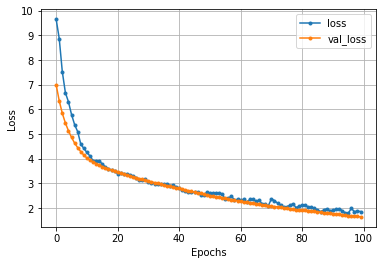

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig("./DNN_fingerprint_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

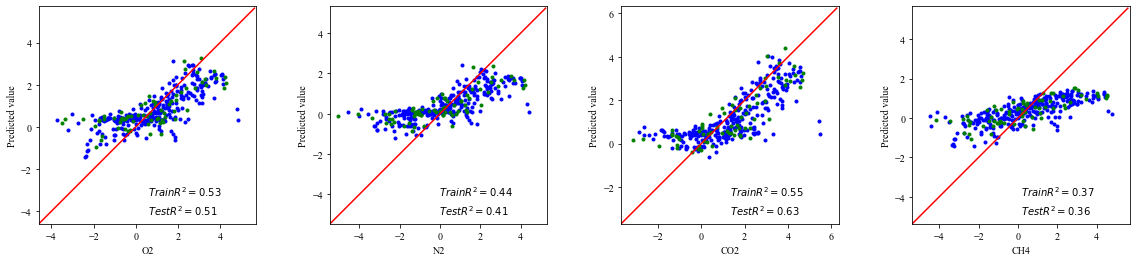

In [11]:
Columns = ['O2','N2','CO2','CH4']
Y_pred_train = model.predict((X_train))
Y_pred_test = model.predict((X_test))
Y_train = Y_train.to_numpy()
Y_test  = Y_test.to_numpy()
plt.figure(figsize=(20,4))
for i in range(4):
    ax=plt.subplot(1, 4, i + 1)
    index = i + 2
    #flag1 = ~np.isnan(Y_train[:,index])
    plt.plot(Y_train[:,index], Y_pred_train[:,index], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, Y_pred_train)))
    #flag2 = ~np.isnan(Y_test[:,index])
    plt.plot(Y_test[:,index], Y_pred_test[:,index], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, Y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(Y_train[:,index]), max(Y_train[:,index])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(Y_train[:,index], Y_pred_train[:,index])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(Y_test[:,index], Y_pred_test[:,index])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')